# Prepare

In [1]:
import torch

torch.cuda.empty_cache()

In [2]:
import argparse
import json
import os

import numpy as np
import sklearn.metrics
import torch
from torch import optim

from lib.suggested.self_attention_with_cnn import SelfAttentionCnnClassifier
from lib.embedding import load_full_embedding_with_vocab
from lib.reader import WikiqaReader, filtered_ref_generator
from lib.train import train_model, get_label_score
from lib.transformer import NoamOpt

Debugging


In [3]:
config_path = 'models/suggested/self_attention_with_cnn/config.json'

In [4]:
with open(config_path, 'r') as fread:
    config_dict = json.load(fread)

# path
path_config = config_dict['Path']
model_dir = path_config['model_dir']
train = path_config['train']
dev = path_config['dev']
dev_ref = path_config['dev_ref']
test = path_config['test']
test_ref = path_config['test_ref']

words_embed, words_vocab = load_full_embedding_with_vocab(path_config['embed_dir'])
vocabs = {'q_words': words_vocab, 'a_words': words_vocab}

# model
model_config = config_dict['Model']
conv_width = model_config['conv_width']
out_channels = model_config['out_channels']
hidden_size = model_config['hidden_size']
cuda_device = model_config['cuda_device']
dropout = model_config['dropout']
h = model_config['h']
d_ff = model_config['d_ff']

In [5]:
import importlib
import lib.suggested.self_attention_with_cnn
importlib.reload(lib.suggested.self_attention_with_cnn)

SelfAttentionCnnClassifier = lib.suggested.self_attention_with_cnn.SelfAttentionCnnClassifier

clf = SelfAttentionCnnClassifier(words_embed=words_embed, out_channels=out_channels,
            conv_width=conv_width, hidden_size=hidden_size, cuda_device=None,
            h=h, d_ff=d_ff, dropout=dropout)

In [6]:
clf.load_state_dict(torch.load(os.path.join(model_dir, 'net.pt')))

In [7]:
dev_reader = WikiqaReader(dev, PAD_TOKEN='<pad>')
dev_reader.set_vocabs(vocabs)

dev_iterator = dev_reader.get_dataset_iterator(10, train=True)

# gradient

In [8]:
from lib.train import train_model

In [9]:
optimizer = torch.optim.Adam(clf.parameters())

In [10]:
train_model(clf, optimizer, dev_iterator, label_name='label',
            num_epoch=1, cuda_device=None, early_stopping=0,
            input_names=['q_words', 'a_words'], callback=None, verbose=False)

---

In [22]:
print(clf.a_mha2.linears[3].weight.grad)
print(clf.a_mha2.linears[3].weight.grad.std())

tensor([[-0.0007,  0.0018, -0.0000,  ...,  0.0021, -0.0002, -0.0013],
        [ 0.0018, -0.0022,  0.0007,  ..., -0.0054, -0.0056,  0.0027],
        [-0.0101,  0.0101,  0.0043,  ...,  0.0022, -0.0037, -0.0050],
        ...,
        [ 0.0011, -0.0027,  0.0006,  ..., -0.0006,  0.0024, -0.0006],
        [ 0.0014, -0.0042, -0.0017,  ..., -0.0027,  0.0006, -0.0012],
        [-0.0033,  0.0021,  0.0041,  ...,  0.0040,  0.0018, -0.0002]])
tensor(0.0039)


In [26]:
print(clf.hidden1.weight.grad)
print(clf.hidden1.weight.grad.std())

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0001,  0.0001, -0.0000,  ...,  0.0000, -0.0001, -0.0001],
        [ 0.0082,  0.0016,  0.0099,  ..., -0.0125,  0.0117,  0.0069],
        [ 0.0001,  0.0002,  0.0012,  ..., -0.0019, -0.0004, -0.0010]])
tensor(0.0034)


In [23]:
print(clf.a_mha2.linears[0].weight.grad)
print(clf.a_mha2.linears[0].weight.grad.std())

tensor([[ 0.0006, -0.0004, -0.0011,  ..., -0.0011,  0.0012, -0.0019],
        [-0.0001,  0.0037,  0.0013,  ..., -0.0014, -0.0006,  0.0018],
        [ 0.0003,  0.0055, -0.0015,  ...,  0.0005,  0.0010, -0.0011],
        ...,
        [ 0.0009,  0.0004,  0.0012,  ..., -0.0027, -0.0001, -0.0012],
        [-0.0007,  0.0024, -0.0028,  ...,  0.0035, -0.0004,  0.0021],
        [-0.0005,  0.0007, -0.0011,  ...,  0.0009,  0.0004,  0.0007]])
tensor(0.0023)


In [24]:
print(clf.a_mha2.linears[1].weight.grad)
print(clf.a_mha2.linears[1].weight.grad.std())

tensor([[-0.0033,  0.0002, -0.0029,  ...,  0.0054,  0.0009, -0.0010],
        [ 0.0006,  0.0009,  0.0002,  ...,  0.0004, -0.0009, -0.0017],
        [ 0.0005, -0.0005, -0.0015,  ...,  0.0010,  0.0003, -0.0009],
        ...,
        [-0.0004, -0.0038, -0.0001,  ...,  0.0007, -0.0022,  0.0001],
        [ 0.0002, -0.0016, -0.0024,  ...,  0.0049,  0.0008,  0.0028],
        [-0.0018,  0.0035, -0.0093,  ...,  0.0129, -0.0008,  0.0004]])
tensor(0.0029)


# Attention Visualization

In [11]:
import matplotlib.pyplot as plt

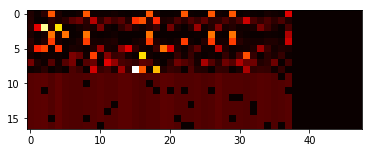

In [13]:
plt.imshow(clf.q_mha2.attn[0][0].detach().numpy(), cmap='hot', interpolation='nearest',)
# plt.xticks(np.arange(10), labels=tokens)
# plt.yticks(np.arange(10), labels=tokens)

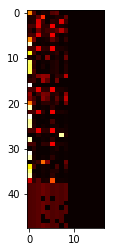

In [14]:
plt.imshow(clf.a_mha2.attn[0][0].detach().numpy(), cmap='hot', interpolation='nearest',)
# plt.xticks(np.arange(10), labels=tokens)
# plt.yticks(np.arange(10), labels=tokens)